# Recurrent non-synonymous mutations as determined by SUFAM

In [63]:
import pandas as pd
import numpy as np
import glob
import os
%matplotlib inline
import seaborn as sns
sns.set_style('white')

In [2]:
INPUT_FILES = {
    # should be all samples run through sufam on set of all NS mutations in all samples
    "sufam":"ALL_SUFAM",
    # should be the vcf as supplied to sufam with annotations
    "ann":"SUFAM_ANNOTATIONS_VCF"
}

In [59]:
PARAMETERS = {
    # should be a number, show only genes/mutations with x number of samples supporting it
    "min_nr_samples_with_mutation":int("MIN_NR_SAMPLES_WITH_MUTATION"),
    # should be a list of names
    "sample_order":"SAMPLE_ORDER".split()
}

In [4]:
df = pd.read_csv(INPUT_FILES["sufam"], dtype={"chrom":str}, sep="\t")

In [5]:
dfa = df.join(pd.read_csv(INPUT_FILES["ann"], dtype={"#CHROM":str}, sep="\t", na_values=".")\
        .rename(columns={"#CHROM":"chrom",
                         "REF":"val_ref",
                         "ALT":"val_alt",
                         "POS":"pos"})\
        .set_index("chrom pos val_ref val_alt".split()),
        on=["chrom","pos","val_ref","val_alt"])

In [6]:
split = pd.DataFrame(dfa["ANN[*].GENE"].str.split("|").tolist(), index=dfa.index).stack()
split.name = "GENE_SPLIT"
split.index = split.index.droplevel(-1)
dfa_split = dfa.join(pd.DataFrame({"GENE_SPLIT":split,
              "IMPACT_SPLIT":[s for l in dfa["ANN[*].IMPACT"].str.split("|").tolist() for s in l]}, index=split.index))
dfa_split.index = list(range(len(dfa_split)))

In [54]:
dfa['ANN[*].HGVS_P'] = dfa['ANN[*].HGVS_P'].apply(lambda x: x.split('|')[-1] if hasattr(x, 'split') else np.nan)
dfa['ANN[*].GENE'] = dfa['ANN[*].GENE'].apply(lambda x: x.split('|')[-1] if hasattr(x, 'split') else np.nan)
identical_mut_maf = dfa[(dfa["ANN[*].IMPACT"].str.contains("MODERATE") | dfa["ANN[*].IMPACT"].str.contains("HIGH")) & (dfa.val_maf > 0)].groupby(["sample", "chrom", "pos", "val_ref", "val_alt", "ANN[*].GENE", "ANN[*].HGVS_P"]).val_maf.max().unstack("sample").fillna(0)
identical_mut_maf = identical_mut_maf.reindex_axis(PARAMETERS["sample_order"], axis=1)

## What is the MAF of the NS mutation(s)?

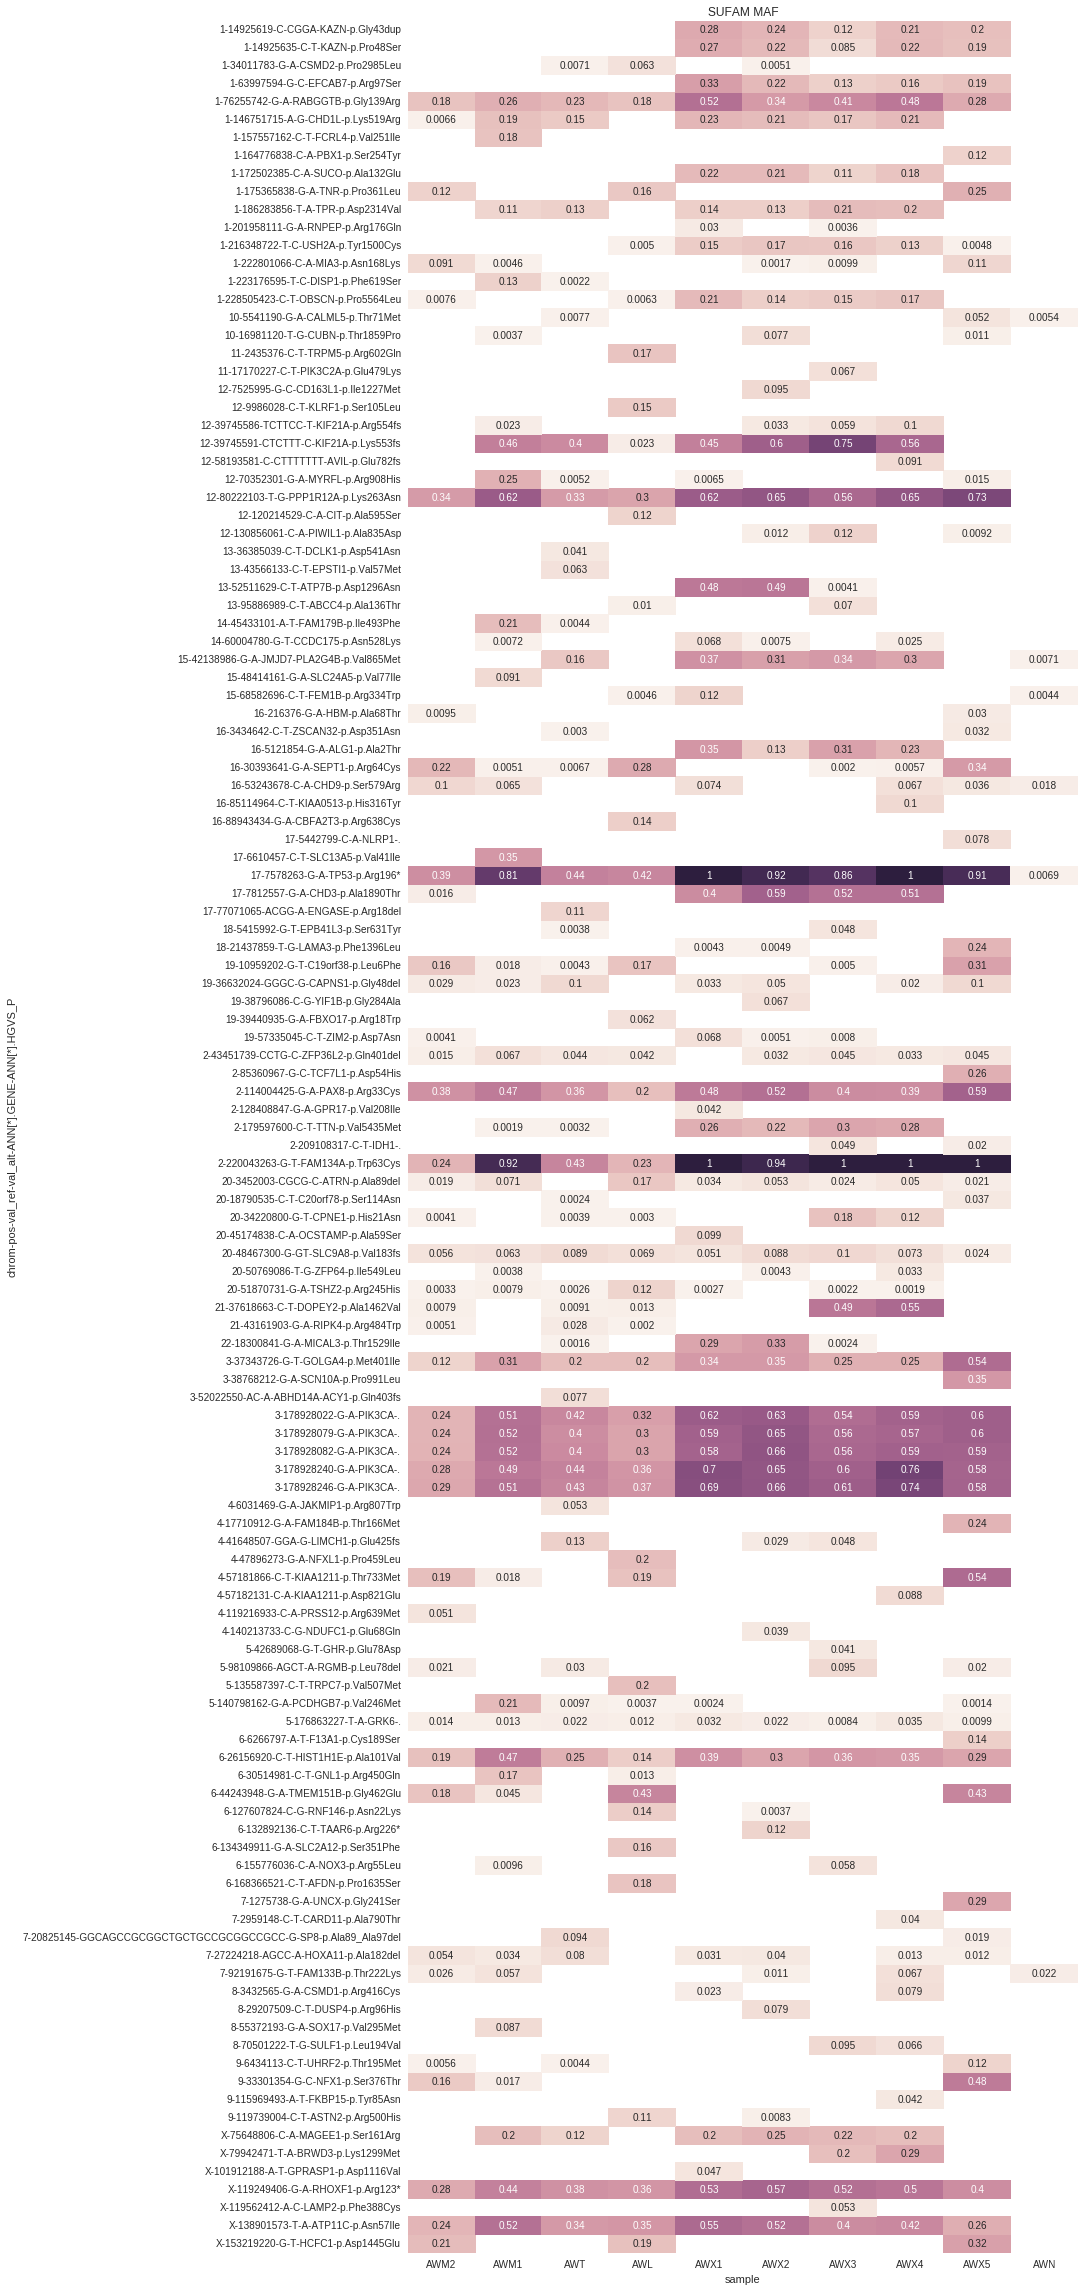

In [64]:
sns.plt.figure(figsize=(12,40))
h = sns.heatmap(identical_mut_maf[identical_mut_maf.astype(bool).apply(lambda x: x.sum(), axis = 1) >= PARAMETERS["min_nr_samples_with_mutation"]], 
               mask=~identical_mut_maf.astype(bool)[identical_mut_maf.astype(bool).apply(lambda x: x.sum(), axis = 1) >= PARAMETERS["min_nr_samples_with_mutation"]],
                cbar=False, annot=True)
sns.plt.title("SUFAM MAF")
sns.plt.savefig('sufam_maf_per_mutation.pdf', bbox_inches='tight')

## What is the max MAF of each gene with NS mutation(s)?

In [13]:
gene_max_maf = dfa_split[dfa_split["IMPACT_SPLIT"].isin(["MODERATE", "HIGH"]) & (dfa_split.val_maf > 0)].groupby(["sample", "GENE_SPLIT"]).val_maf.max().unstack("sample").fillna(0)
gene_max_maf = gene_max_maf.reindex_axis(PARAMETERS["sample_order"], axis=1)

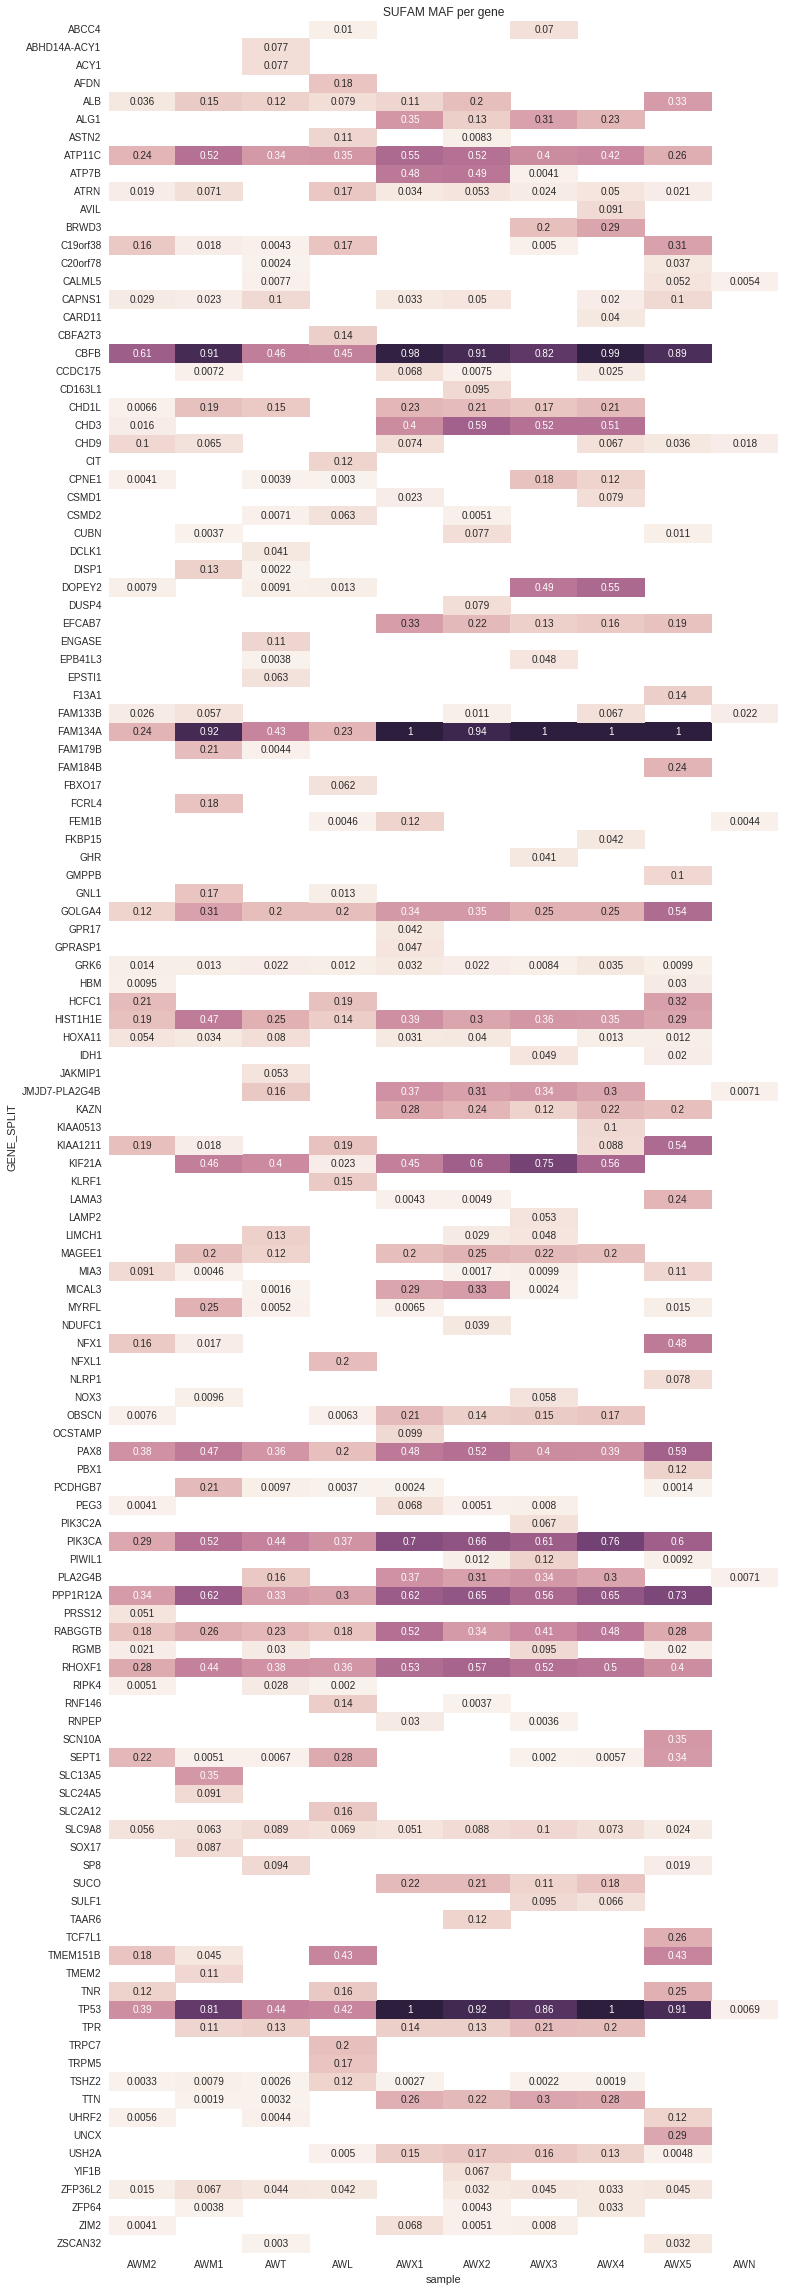

In [66]:
f = sns.plt.figure(figsize=(12,40))

h = sns.heatmap(gene_max_maf[gene_max_maf.astype(bool).apply(lambda x: x.sum(), axis = 1) >= PARAMETERS["min_nr_samples_with_mutation"]],
                mask=~gene_max_maf.astype(bool)[gene_max_maf.astype(bool).apply(lambda x: x.sum(), axis = 1) >= PARAMETERS["min_nr_samples_with_mutation"]],
                annot=True, cbar=False)
sns.plt.title("SUFAM MAF per gene")
labels = h.set_yticklabels(h.get_yticklabels(), rotation=0)
sns.plt.savefig('sufam_maf_per_gene.pdf', bbox_inches='tight')